# Grokking
Can we observe grokking on modular addition in a toy example?

## setup

In [201]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random

In [202]:
# hyperparameters
split = 0.3
n_vocab = 53
# n_vocab = 113
n_embed = 200
n_hidden = 32
epoch = 50000
learning_rate = 1e-3
device = 'cuda'


In [203]:
# make a training set
random.seed(0xdeadbeef)
X = [(i, j)for i in range(n_vocab) for j in range(n_vocab)]
random.shuffle(X)

X_train = X[: int(len(X) * split)]
X_test = X[int(len(X) * split):]

Y_train = [(i + j) % n_vocab for i, j in X_train]
Y_test =  [(i + j) % n_vocab for i, j in X_test]

# list(zip(X_train, Y_train))[:10]

In [204]:
def get_batch(name='train'):
    return {
        'train': (torch.tensor(X_train).to(device), torch.tensor(Y_train).to(device)),
        'test': (torch.tensor(X_test).to(device), torch.tensor(Y_test).to(device))
    }[name]

# get_batch('test')

## model

In [205]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed = nn.Embedding(n_vocab, n_embed)
        self.layers = nn.Sequential(
            nn.Linear(n_embed, n_hidden),
            nn.ReLU(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(n_hidden),
            nn.Linear(n_hidden, n_vocab))

    def forward(self, x):
        # x shape [30%, 2]
        a, b = x[:, 0], x[:, 1]
        # compute embedding
        a_embed = self.embed(a)
        b_embed = self.embed(b)
        # merge them (could have been a torch.cat() instead?)
        embd = a_embed + b_embed
        # print(f'{a_embed.shape=}, {b_embed.shape=}')
        # embd = torch.cat((a_embed, b_embed), dim=1)
        # print(f'{embd.shape=}')
        return self.layers(embd)
    
model = NN().to(device)
# model(torch.tensor([[2, 3], [3, 4]]))

In [206]:
# 2 options for composition of the 2 inputs
# a = F.one_hot(torch.tensor(1), 3)
# b = F.one_hot(torch.tensor(2), 3)

# torch.cat((a, b))
# a + b

## train

In [207]:
# train
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1)

def evaluate(name):
    X, Y = get_batch(name)
    Y_hat = model(X)
    loss = F.cross_entropy(Y_hat, F.one_hot(Y, n_vocab).float())
    return loss

@torch.no_grad()
def evaluate_test():
    return evaluate('test')

def evaluate_train():
    return evaluate('train')

losses = []
test_losses = []

for i in range(epoch):
    loss = evaluate_train()
    test_loss = evaluate_test()
    losses.append(loss)
    test_losses.append(test_loss)    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 50 == 49:
        print(f'{i=}, {loss=}, {test_loss=}')

i=49, loss=tensor(3.5379, device='cuda:0', grad_fn=<DivBackward1>), test_loss=tensor(4.1962, device='cuda:0')
i=99, loss=tensor(2.7196, device='cuda:0', grad_fn=<DivBackward1>), test_loss=tensor(4.8648, device='cuda:0')
i=149, loss=tensor(1.8176, device='cuda:0', grad_fn=<DivBackward1>), test_loss=tensor(5.6532, device='cuda:0')
i=199, loss=tensor(1.0876, device='cuda:0', grad_fn=<DivBackward1>), test_loss=tensor(6.6621, device='cuda:0')
i=249, loss=tensor(0.5835, device='cuda:0', grad_fn=<DivBackward1>), test_loss=tensor(7.9866, device='cuda:0')
i=299, loss=tensor(0.3037, device='cuda:0', grad_fn=<DivBackward1>), test_loss=tensor(9.3529, device='cuda:0')
i=349, loss=tensor(0.1842, device='cuda:0', grad_fn=<DivBackward1>), test_loss=tensor(10.3157, device='cuda:0')
i=399, loss=tensor(0.1345, device='cuda:0', grad_fn=<DivBackward1>), test_loss=tensor(10.8170, device='cuda:0')
i=449, loss=tensor(0.1105, device='cuda:0', grad_fn=<DivBackward1>), test_loss=tensor(11.0475, device='cuda:0')


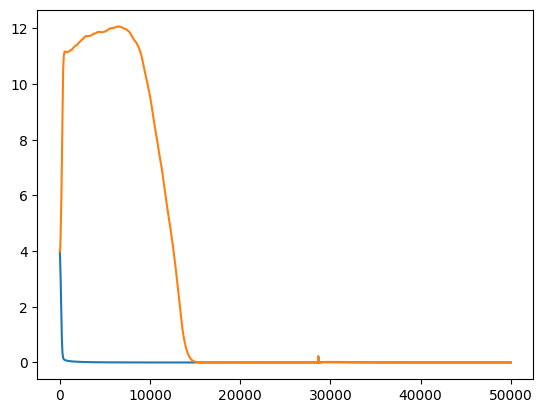

In [211]:
import matplotlib.pyplot as plt
%matplotlib inline

xs = torch.arange(epoch)

plt.plot(xs, torch.tensor(losses).tolist(), label='train')
plt.plot(xs, torch.tensor(test_losses).tolist(), label='test')

## use it ?

In [217]:
y = model(torch.tensor([[2, 3], [3, 4], [33, 48]]).to(device)).argmax(dim=-1)

y

tensor([ 5,  7, 28], device='cuda:0')

In [218]:
(33 + 48) % 53

28